In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
from src.dataset.loader import define_path
from src.dataset.trans.data import TransDataset, extract_pred_sequence
from src.dataset.trans.jaad_trans import JaadTransDataset
from src.dataset.intention.jaad_dataset import build_pedb_dataset_jaad, subsample_and_balance
import cv2
import numpy as np
import glob
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

from src.dataset.loader import PaddedSequenceDataset, IntentionSequenceDataset
from src.transform.preprocess import ImageTransform, Compose, CropBox
import torchvision
import torch

from sklearn.metrics import average_precision_score, f1_score, classification_report
from train_hybrid import unpack_batch
from tqdm import tqdm

In [10]:
anns_paths, image_dir = define_path(use_jaad=True, use_pie=False, use_titan=False)
anns_paths_val, image_dir_val = define_path(use_jaad=True, use_pie=False, use_titan=False)

In [15]:
from dataclasses import dataclass

@dataclass
class Args:
    encoder_type: str = 'CC'
    encoder_pretrained: bool = False
    epochs: int = 1
    lr: float = 0.001
    wd: float = 0.0
    batch_size: int = 4
    max_frames: int = 10
    pred: int = 10
    output: str = None
    fps: int = 5
    seed: int = 99
    jitter_ratio: float = -1.0
    mobilenetsmall: bool = False
    mobilenetbig: bool = False
    num_workers: int = 4

args = Args(num_workers=0)
max_frames = 10

In [18]:
image_set = "test"


intent_sequences = build_pedb_dataset_jaad(anns_paths["JAAD"]["anns"], anns_paths["JAAD"]["split"], image_set=image_set, fps=args.fps, prediction_frames=args.pred, verbose=True)
balance = False if image_set == "test" else True
intent_sequences_cropped = subsample_and_balance(intent_sequences, max_frames=args.max_frames, seed=args.seed, balance=balance)

jitter_ratio = None if args.jitter_ratio < 0 else args.jitter_ratio
crop_preprocess = CropBox(size=224, padding_mode='pad_resize', jitter_ratio=jitter_ratio)
if image_set == 'train':
    TRANSFORM = Compose([
        #crop_preprocess,
        ImageTransform(torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1))
        ])
else:
    TRANSFORM = None #crop_preprocess

ds = IntentionSequenceDataset(intent_sequences_cropped[:500], image_dir=image_dir, hflip_p = 0.5, preprocess=TRANSFORM)

----------------------------------------------------------------
JAAD:
Total number of crosses: 4002
Total number of non-crosses: 2196
Filtered samples: 17
Total number of samples before and after balancing: 3794, 3794


torch.Size([10, 3, 1080, 1920])


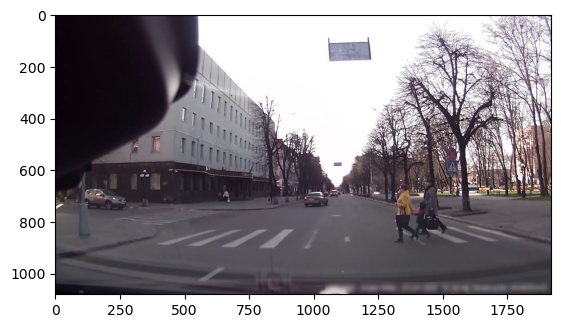

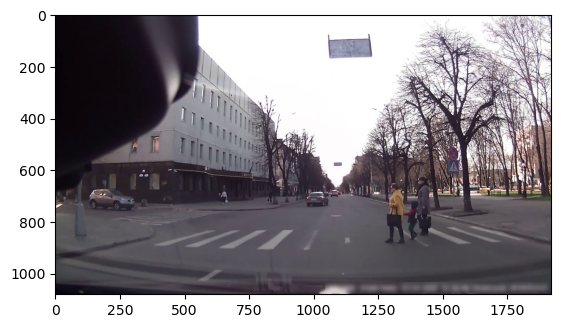

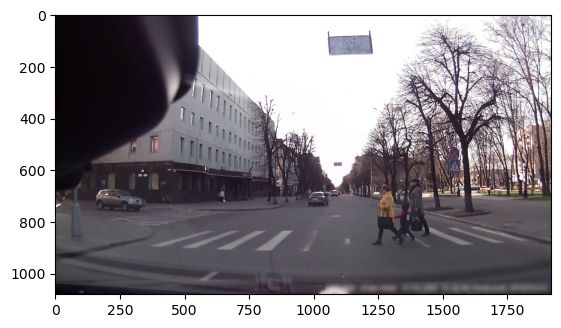

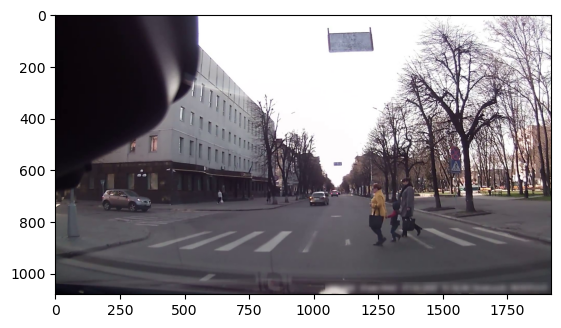

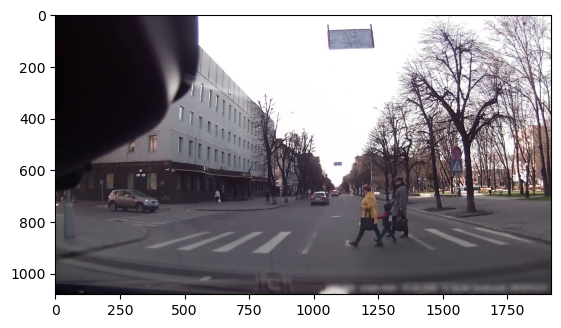

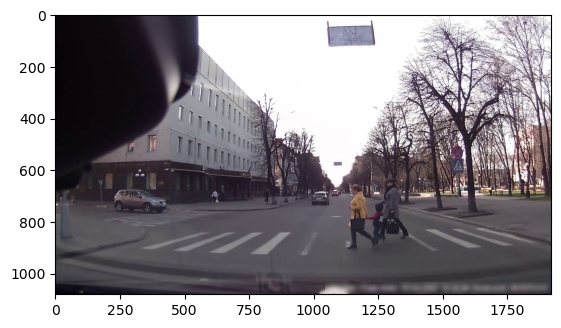

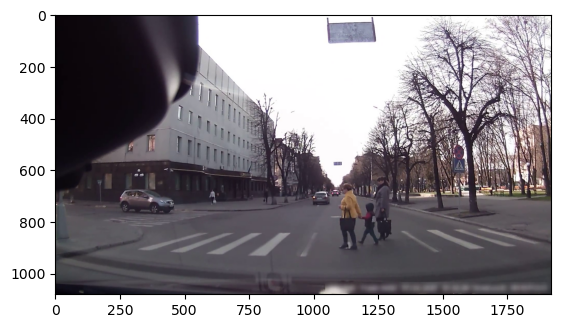

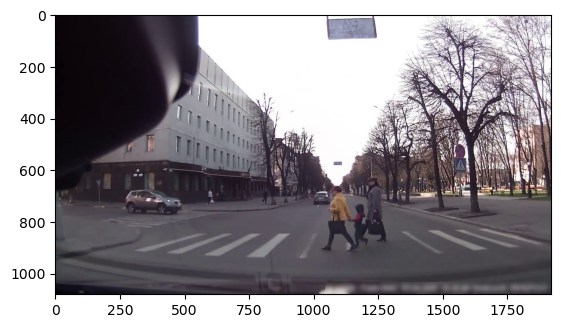

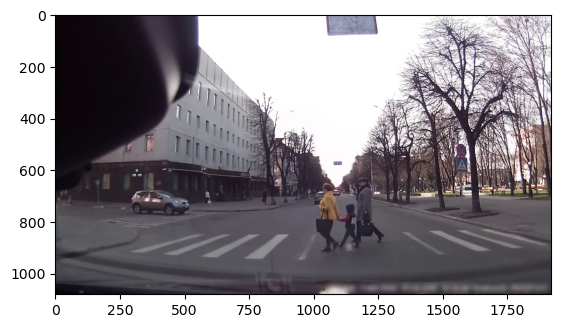

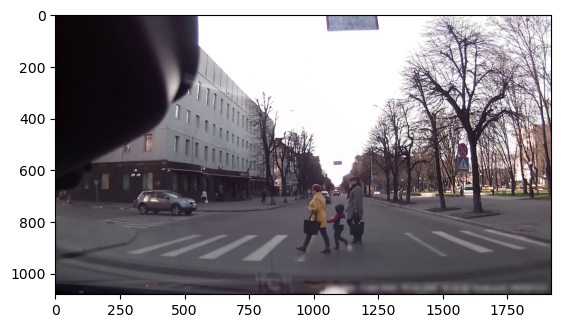

In [19]:
for el in ds:
    print(el['image'].shape)
    for img in el['image']:
        plt.imshow(img.permute(1,2,0))
        plt.show()
    break

In [6]:
from src.model.models import build_encoder_res18, DecoderRNN_IMBS
from src.early_stopping import load_from_checkpoint

CP_PATH = 'D:\VisualStudioProgram\CIVIL459-PedestrianIntensionDetection\checkpoints\silver-sweep-5\Decoder_IMBS_lr0.001_wd0.0001_JAAD_mf10_pred10_bs16_202305241656.pt'

In [7]:
device = torch.device('cpu')


encoder_res18 = build_encoder_res18(args)
# freeze CNN-encoder during training
encoder_res18.freeze_backbone()

decoder_lstm = DecoderRNN_IMBS(CNN_embeded_size=256, h_RNN_0=256, h_RNN_1=64, h_RNN_2=16,
                                h_FC0_dim=128, h_FC1_dim=64, h_FC2_dim=86, drop_p=0.2).to(device)

model = {'encoder': encoder_res18, 'decoder': decoder_lstm}
load_from_checkpoint(model, CP_PATH)

Using resnet18 cnn encoder!!


In [19]:
@torch.no_grad()
def abl_eval_model(loader, model, device, abl_type='none'):
    # swith to evaluate mode
    encoder_CNN, decoder_RNN = model['encoder'], model['decoder']
    encoder_CNN.eval()
    decoder_RNN.eval()

    batch_size = loader.batch_size
    n_steps = len(loader)

    preds = np.zeros(n_steps * batch_size)
    tgts = np.zeros(n_steps * batch_size)

    for step, inputs in enumerate(tqdm(loader)):
        images, seq_len, pv, scene, behavior, targets = unpack_batch(inputs, device)
        outputs_CNN = encoder_CNN(images, seq_len)
        if abl_type == 'CNN':
            outputs_CNN = torch.zeros_like(outputs_CNN)
        elif abl_type == 'scene':
            scene = torch.zeros_like(scene)
        elif abl_type == 'behavior':
            behavior = torch.zeros_like(behavior)
        elif abl_type == 'pv':
            pv = torch.zeros_like(pv)
        elif abl_type == 'only_scene':
             outputs_CNN = torch.zeros_like(outputs_CNN)
             behavior = torch.zeros_like(behavior)
             pv = torch.zeros_like(pv)
        outputs_RNN = decoder_RNN(xc_3d=outputs_CNN, xp_3d=pv, 
                                    xb_3d=behavior, xs_2d=scene, x_lengths=seq_len)
        
        preds[step * batch_size: (step + 1) * batch_size] = outputs_RNN.detach().cpu().squeeze()
        tgts[step * batch_size: (step + 1) * batch_size] = targets.detach().cpu().squeeze()

    ap_score = average_precision_score(tgts, preds)
    best_thr = decoder_RNN.threshold
    f1 = f1_score(tgts, preds > best_thr)
    preds = preds > best_thr
    print(classification_report(tgts, preds), flush=True)
    print(f"AP: {ap_score}, F1: {f1}", flush=True)

In [11]:
test_loader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=False, num_workers=args.num_workers, pin_memory=True)


In [12]:
abl_eval_model(test_loader, model, device)

100%|██████████| 500/500 [15:25<00:00,  1.85s/it]

              precision    recall  f1-score   support

         0.0       0.52      0.58      0.54       147
         1.0       0.81      0.77      0.79       353

    accuracy                           0.72       500
   macro avg       0.67      0.68      0.67       500
weighted avg       0.73      0.72      0.72       500

AP: 0.8261949193522153, F1: 0.7936046511627906


In [13]:
abl_eval_model(test_loader, model, device, abl_type='CNN')

100%|██████████| 500/500 [18:42<00:00,  2.24s/it]

              precision    recall  f1-score   support

         0.0       0.52      0.58      0.55       147
         1.0       0.82      0.78      0.80       353

    accuracy                           0.72       500
   macro avg       0.67      0.68      0.67       500
weighted avg       0.73      0.72      0.72       500

AP: 0.8342055905865203, F1: 0.7971014492753623


In [14]:
abl_eval_model(test_loader, model, device, abl_type='pv')

100%|██████████| 500/500 [19:48<00:00,  2.38s/it]

              precision    recall  f1-score   support

         0.0       0.62      0.42      0.50       147
         1.0       0.79      0.89      0.84       353

    accuracy                           0.75       500
   macro avg       0.70      0.66      0.67       500
weighted avg       0.74      0.75      0.74       500

AP: 0.8261691528741337, F1: 0.8366533864541833


In [15]:
abl_eval_model(test_loader, model, device, abl_type='behavior')

100%|██████████| 500/500 [18:41<00:00,  2.24s/it]

              precision    recall  f1-score   support

         0.0       0.43      0.65      0.52       147
         1.0       0.81      0.65      0.72       353

    accuracy                           0.65       500
   macro avg       0.62      0.65      0.62       500
weighted avg       0.70      0.65      0.66       500

AP: 0.8039681742822548, F1: 0.722397476340694


In [16]:
abl_eval_model(test_loader, model, device, abl_type='scene')

100%|██████████| 500/500 [16:48<00:00,  2.02s/it]

              precision    recall  f1-score   support

         0.0       0.29      1.00      0.45       147
         1.0       0.00      0.00      0.00       353

    accuracy                           0.29       500
   macro avg       0.15      0.50      0.23       500
weighted avg       0.09      0.29      0.13       500

AP: 0.7711817595235823, F1: 0.0



d:\VisualStudioProgram\CIVIL459-PedestrianIntensionDetection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\VisualStudioProgram\CIVIL459-PedestrianIntensionDetection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\VisualStudioProgram\CIVIL459-PedestrianIntensionDetection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contro

In [20]:
abl_eval_model(test_loader, model, device, abl_type='only_scene')

100%|██████████| 500/500 [16:20<00:00,  1.96s/it]

              precision    recall  f1-score   support

         0.0       0.60      0.41      0.49       147
         1.0       0.78      0.89      0.83       353

    accuracy                           0.75       500
   macro avg       0.69      0.65      0.66       500
weighted avg       0.73      0.75      0.73       500

AP: 0.79495317200476, F1: 0.8313413014608233
